In [1]:
import torch
import matplotlib.pyplot as plt
from src.models.localization.cnn_localizer import CNNLocalizer
from src.util.loss_funcs import localization_loss
from src.util.transform_dataset import TransformDataset, get_transform
import torch.nn.functional as F
from itertools import product

# Setup and constants

In [2]:
torch.manual_seed(123)
torch.set_default_dtype(torch.float32) # TODO maybe remove
batch_size = 128

# Model definition

done in separate file

## Localization


done in separate file

### Load data and preprocessing

done in seperate file

In [3]:
def intersection(bb1, bb2):
    left = max(bb1[0] - bb1[2]/2, bb2[0] - bb2[2]/2)
    right = min(bb1[0] + bb1[2]/2, bb2[0] + bb2[2]/2)
    top = max(bb1[1] - bb1[3]/2, bb2[1] - bb2[3]/2)
    bot = min(bb1[1] + bb1[3]/2, bb2[1] + bb2[3]/2)

    if left >= right or top >= bot:
        return 0
    
    width = right - left
    height = bot - top

    return width*height
   
def IoU(bb1, bb2):
    intersect_area = intersection(bb1, bb2)
    return intersect_area / (bb1[2]*bb1[3] + bb2[2] * bb2[3] - intersect_area)
   
def compute_IoU_localization(model, loader, preprocessor):
    """
    Compute IoU performance of the model on the given dataset
    """
    IoU_scores = []
    for images, labels in loader:
        out = model.predict(images)
        for pred, target in zip(out, labels):
            bb1 = pred[1:5]
            bb2 = target[1:5]
            predicted_detection = F.sigmoid(pred[0]).item() > 0.5
            IoU_scores.append(IoU(bb1, bb2) if target[0] else predicted_detection == False)
    
    return torch.mean(torch.Tensor(IoU_scores))


def compute_accuracy_localization(model, loader, preprocessor):
    """
    Compute accuracy of the model on the given dataset
    """
    accuracy_scores = []
    for images, labels in loader:
        out = model.predict(images)
        for pred, target in zip(out,labels):
            predicted_detection = F.sigmoid(pred[0]).item() > 0.5
            accuracy_scores.append(pred[5] == target[5] and predicted_detection == target[0] or not target[0] and not predicted_detection)
            
    return torch.mean(torch.Tensor(accuracy_scores))

In [4]:
train = torch.load("data/localization_train.pt", weights_only=False)
train_transform = get_transform(train.tensors[0])
train = TransformDataset(train, train_transform)

val = torch.load("data/localization_val.pt", weights_only=False)
val = TransformDataset(val, train_transform)

test = torch.load("data/localization_test.pt", weights_only=False)
test = TransformDataset(test, train_transform)


# TODO seed data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)


In [5]:
from src.models.localization import cnn_localizer, cnn_network_1, resnet

learning_rates = [0.001]
epochs = [20]

models = {}

for learning_rate, num_epochs in product(learning_rates, epochs):
    model = CNNLocalizer(loss_fn=localization_loss, learning_rate=learning_rate, num_epochs=num_epochs, network=resnet.ResNet18Localization)
    model.fit(train_loader)

    IoU_score = compute_IoU_localization(model, val_loader, None)
    accuracy_score = compute_accuracy_localization(model, val_loader, None)

    print(f'Learning rate: {learning_rate}, num_epochs: {num_epochs}')
    print(f'IoU score: {IoU_score}')
    print(f'Accuracy score: {accuracy_score}')
    models[model] = (IoU_score+accuracy_score) / 2

running on: mps


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20 — Loss: 598.7178856134415
Epoch 2/20 — Loss: 182.3710184842348
Epoch 3/20 — Loss: 123.03787329047918
Epoch 4/20 — Loss: 96.80888130888343
Epoch 5/20 — Loss: 71.49216378107667
Epoch 6/20 — Loss: 57.53659512475133
Epoch 7/20 — Loss: 49.277690002694726
Epoch 8/20 — Loss: 39.59929729811847
Epoch 9/20 — Loss: 33.962273203767836
Epoch 10/20 — Loss: 29.316892963834107
Epoch 11/20 — Loss: 25.0939727909863
Epoch 12/20 — Loss: 22.416001541540027
Epoch 13/20 — Loss: 20.07061999756843
Epoch 14/20 — Loss: 17.138919391669333
Epoch 15/20 — Loss: 17.115928796119988
Epoch 16/20 — Loss: 15.868279279675335
Epoch 17/20 — Loss: 15.748592290561646
Epoch 18/20 — Loss: 13.772904524113983
Epoch 19/20 — Loss: 12.215440126135945
Epoch 20/20 — Loss: 13.339276470709592
Learning rate: 0.001, num_epochs: 20
IoU score: 0.6893718242645264
Accuracy score: 0.9353030323982239


### Training

In [6]:
def draw(img, out, target):
    po, xo, yo, wo, ho = out[0:5]
    pt, xt, yt, wt, ht = target[0:5]

    fig, ax = plt.subplots()

    img = img.squeeze(0).numpy()
    ax.imshow(img, cmap="gray")
    ax.axis("off")

    rectOut = plt.Rectangle(((xo-wo/2) * 60, (yo-ho/2)*48), wo*60, ho*48, linewidth=3, edgecolor='r', facecolor='none')
    rectTarget = plt.Rectangle(((xt-wt/2) * 60, (yt-ht/2)*48), wt*60, ht*48, linewidth=3, edgecolor='g', facecolor='none')

    if po > 0:
        ax.add_patch(rectOut)
    ax.add_patch(rectTarget)
    ax.text(0, 53, f"{out},\n{target}")

### Predictions

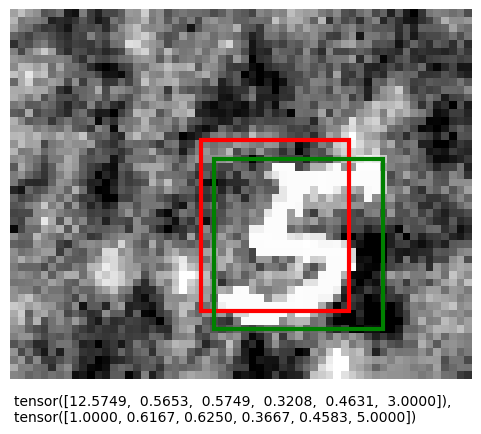

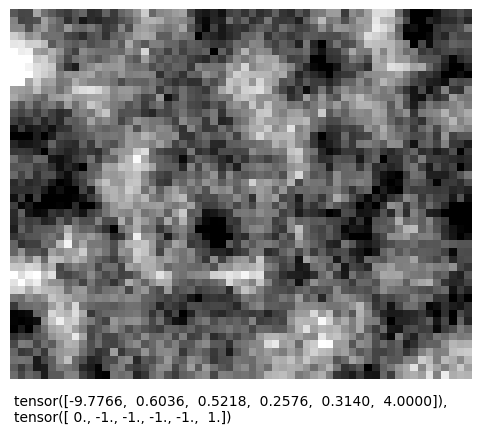

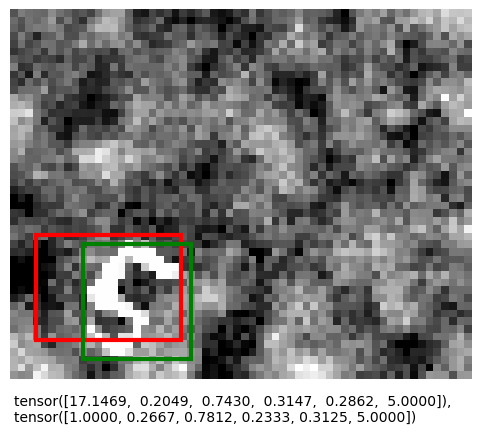

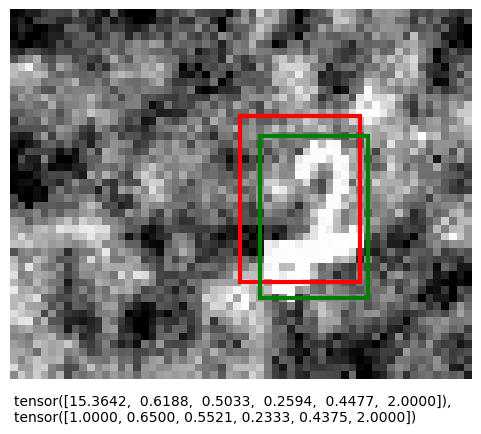

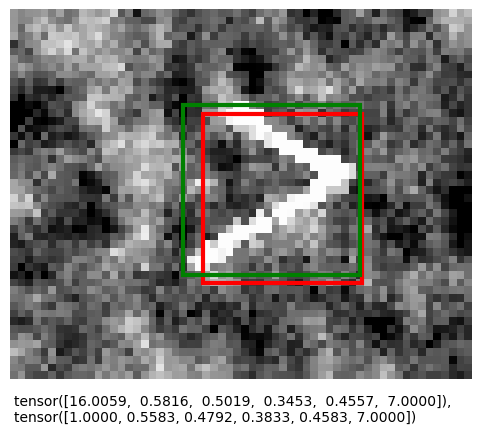

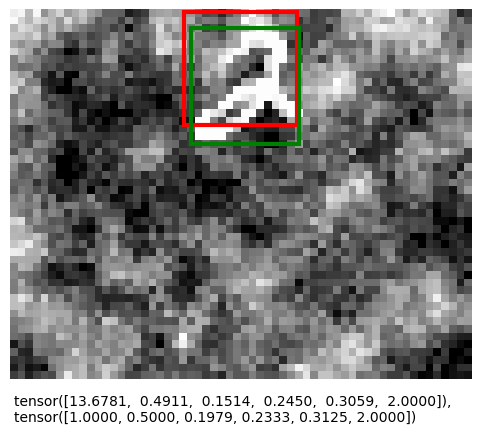

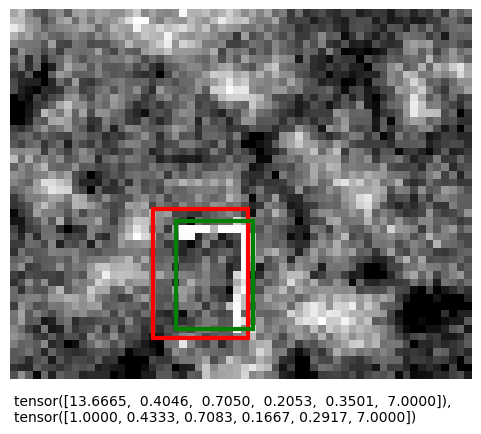

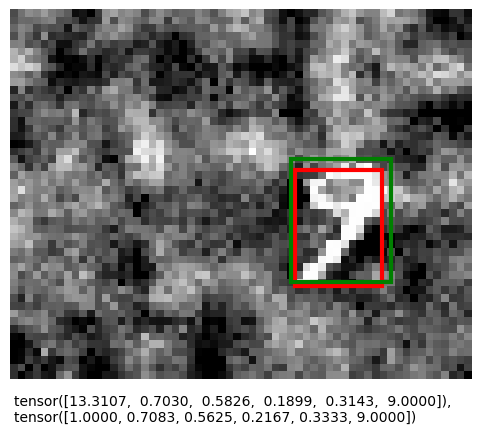

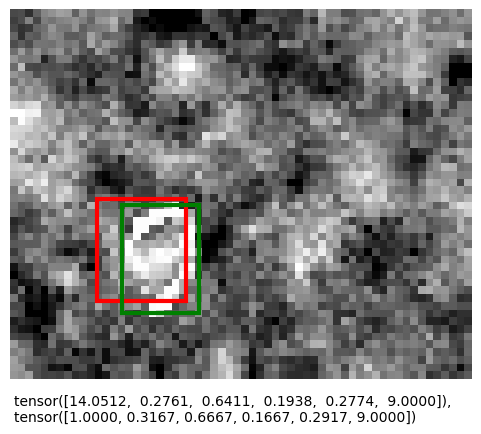

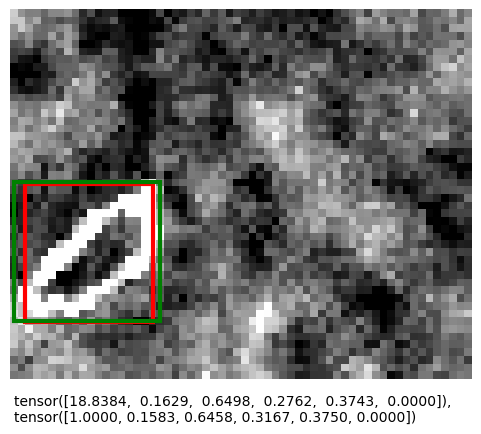

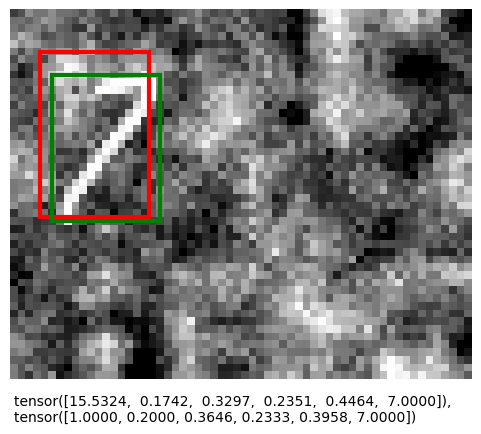

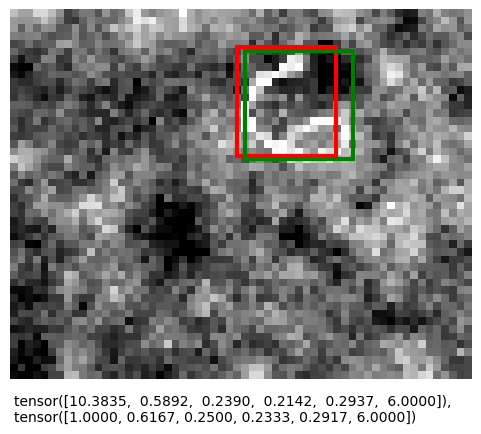

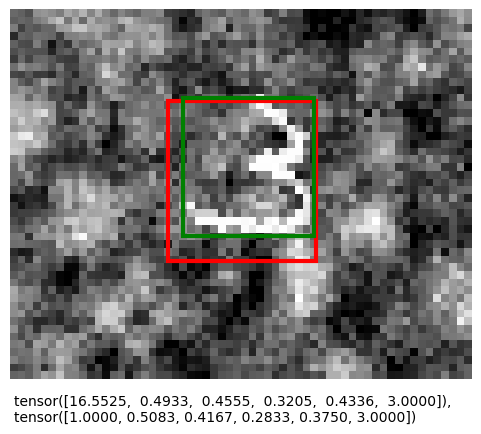

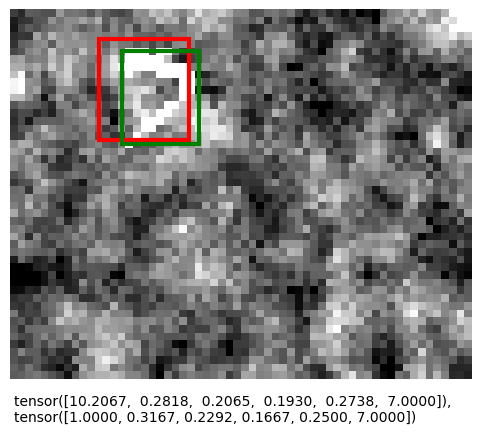

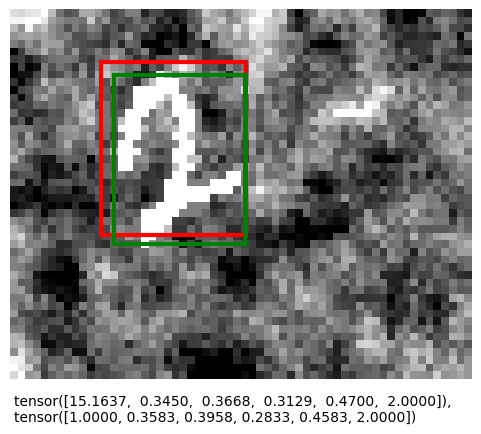

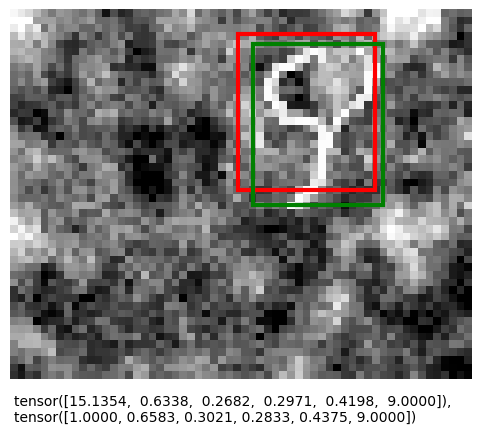

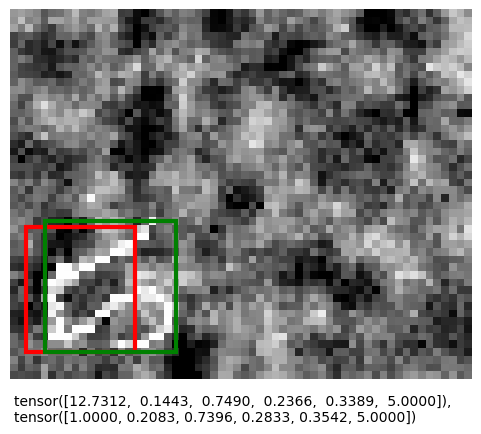

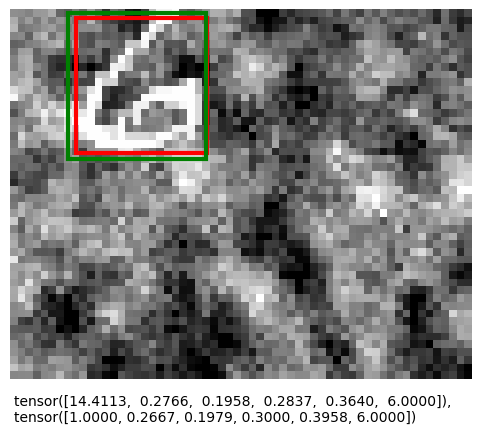

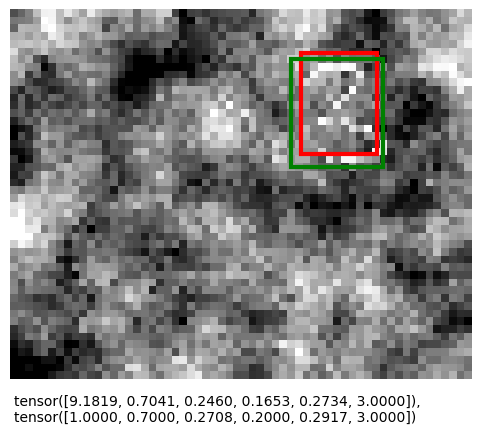

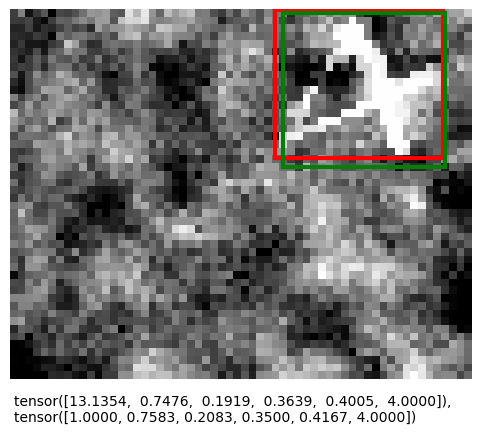

In [7]:
best_model = max(models, key=models.get)
images, labels = next(iter(val_loader))
outs = model.predict(images).cpu()
for i in range(20):
    draw(images[i], outs[i], labels[i])

### Model selection and evaluation